# Differential equations for a pendulum with time-varying length

Based on derivations from
 - https://en.wikipedia.org/wiki/Centripetal_force#Nonuniform_circular_motion

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# This is needed to make debugger work
import sys
sys.breakpointhook = sys.__breakpointhook__

## General planar motion
(not limited to circular motion)

Position of the point load at the end of pendulum arm relative to pivot:

$$\mathbf{r} = r \cos{(\theta)} \mathbf{u}_x + r \sin{(\theta)} \mathbf{u}_y$$

where $\mathbf{u}_x$ and $\mathbf{u}_y$ are unit vectors in the cartesian plane, and $r$, $\theta$ may be time varying

Translate into a polar co-ordinate system which has a radial unit vector $\mathbf{u}_\rho$ and an angular unit vector $\mathbf{u}_\theta$, and moves with the particle.

<img src="images/Polar_unit_vectors.png" width="40%">


$$\mathbf{r} = \rho \mathbf{u}_\rho$$

The unit vector $\mathbf{u}_p$ travels with the particle and always points in the same direction as $\mathbf{r}(t)$. Unit vector $\mathbf{u}_\theta$ also travels with the particle and remains orthogonal to $\mathbf{u}_\rho$. Thus, $\mathbf{u}_\rho$ and $\mathbf{u}_\theta$ form a local Cartesian coordinate system attached to the particle, and tied to the path traveled by the particle.

In [3]:
def xy_to_polar(x, y):
    theta = np.arctan2(y, x)
    L = np.sqrt(x**2 + y**2)
    return [L, theta]

assert(xy_to_polar(0, 0) == [0, 0])
assert(xy_to_polar(1, 0) == [1, 0])
assert(xy_to_polar(0, 2) == [2, 0.5*np.pi])
assert(xy_to_polar(-3, 0) == [3, np.pi])
assert(np.all(np.isclose(xy_to_polar(3, -4), [5, -np.radians(53.13)])))

def polar_to_xy(L, theta):
    x = L * np.cos(theta)
    y = L * np.sin(theta)
    return [x, y]

Velocity of the particle:

$$\mathbf{v} = \frac{d\rho}{dt} \mathbf{u}_p + \rho \frac{d\mathbf{u}_p}{dt}$$

where $\rho$ is used to describe the distance of the path from the origin instead of $r$ to emphasize that it is time-varying.

Considering that $\mathbf{u}_p$ and $\mathbf{u}_\theta$ always form a right-angled pair with tips on the unit circle, their time derivatives are 

$$\frac{d\mathbf{u}_\rho}{dt} = \mathbf{u}_\theta \frac{d\theta}{dt},
\frac{d\mathbf{u}_\theta}{dt} = - \frac{d\theta}{dt} \mathbf{u}_\rho$$

Note: in the image above, to maintain orthogonality, if $d\mathbf{u}_\rho$ is positive with $d\theta$, then $d\mathbf{u}_\theta$ must decrease.

Substituting above into the equation for velocity gives

$$\mathbf{v} = \frac{d\rho}{dt} \mathbf{u}_\rho + \rho \mathbf{u}_\theta \frac{d\theta}{dt}$$

To obtain the acceleration, differentiate again w.r.t. time

$$
\begin{aligned}
    \mathbf{a} &= \frac{d}{dt} \left[ 
        \frac{d\rho}{dt} \mathbf{u}_\rho + \rho \mathbf{u}_\theta \frac{d\theta}{dt}
    \right] \\
    &= \frac{d^2\rho}{{dt}^2} \mathbf{u}_\rho 
        + \frac{d\rho}{dt} \frac{d\mathbf{u}_\rho}{dt}
        + \frac{d\rho}{dt} \mathbf{u}_\theta \frac{d\theta}{dt}
        + \rho \frac{d\mathbf{u}_\theta}{dt} \frac{d\theta}{dt}
        + \rho \mathbf{u}_\theta \frac{d^2\theta}{{dt}^2} \\
    &= \frac{d^2\rho}{{dt}^2} \mathbf{u}_\rho 
        + \frac{d\rho}{dt} \mathbf{u}_\theta \frac{d\theta}{dt}
        + \frac{d\rho}{dt} \mathbf{u}_\theta \frac{d\theta}{dt}
        - \rho \frac{d\theta}{dt} \mathbf{u}_\rho \frac{d\theta}{dt}
        + \rho \mathbf{u}_\theta \frac{d^2\theta}{{dt}^2} \\
    &= \frac{d^2\rho}{{dt}^2} \mathbf{u}_\rho
        + 2 \frac{d\rho}{dt} \mathbf{u}_\theta \frac{d\theta}{dt}
        - \rho \mathbf{u}_\rho \left(\frac{d\theta}{dt}\right)^2
        + \rho \mathbf{u}_\theta \frac{d^2\theta}{{dt}^2} \\
    &= \mathbf{u}_\rho \left[ 
            \frac{d^2\rho}{{dt}^2}
            - \rho \left(\frac{d\theta}{dt}\right)^2 \right]
        + \mathbf{u}_\theta \left[
            2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
            + \rho \frac{d^2\theta}{{dt}^2} \right]
\end{aligned}
$$

Since $\frac{d\rho}{dt} = v_p$ and $\rho \frac{d\theta}{dt} = v_\theta$, we can also write

$$
\mathbf{a} = \mathbf{u}_\rho \left[ 
            \frac{dv_p}{dt}
            - \frac{v_\theta^2}{\rho} \right]
        + \mathbf{u}_\theta \left[
            \frac{2 v_p v_\theta}{\rho} 
            + \rho \frac{d}{dt} \left( \frac{v_\theta}{\rho} \right) \right]
$$

$$
\begin{aligned}
a_\rho &= \frac{d^2\rho}{{dt}^2}
            - \rho \left(\frac{d\theta}{dt}\right)^2 \\
a_\theta &= 2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
            + \rho \frac{d^2\theta}{{dt}^2}
\end{aligned}
$$

therefore

$$
\begin{aligned}
\frac{d^2\rho}{{dt}^2} &= a_\rho
            + \rho \left(\frac{d\theta}{dt}\right)^2 \\
\frac{d^2\theta}{{dt}^2} &= \frac{1}{\rho} \left[
    a_\theta - 2 \frac{d\rho}{dt} \frac{d\theta}{dt}
\right]
\end{aligned}
$$

In [4]:
def centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta):
    """Calculates the second derivatives of the
    radius and angle of the position of a mass 
    (polar co-ordinates), with the given radial and
    angular velocities, and subject to additional 
    accelerations, a_r and a_theta, due to applied
    forces.
    """
    D2_r = a_r + r * D_theta ** 2
    D2_theta = (a_theta - 2 * D_r * D_theta) / r
    return D2_r, D2_theta

In [5]:
r = 5
D_r = 0
a_r = 0
theta = 0  # horizontal (to right)
D_theta = 0
a_theta = 9.81
D2_r, D2_theta = centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta)
assert((D2_r, D2_theta) == (0, a_theta / r))

In [6]:
r = 5
D_r = 0
a_r = 0
theta = -np.pi / 2  # vertical (down)
D_theta = 0
a_theta = 9.81
D2_r, D2_theta = centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta)
assert((D2_r, D2_theta) == (0, a_theta / r))

In [7]:
r = 5
D_r = 1
a_r = 0
theta = np.degrees(45)
D_theta = 0
a_theta = 0
D2_r, D2_theta = centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta)
assert((D2_r, D2_theta) == (0, 0))

In [8]:
r = 5
D_r = 1  # radius extending
a_r = 0
theta = np.degrees(45)
D_theta = 1  # turning anti-clockwise
a_theta = 0
D2_r, D2_theta = centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta)
assert((D2_r, D2_theta) == (5, -0.4))

For comparison, the case of circular motion when $\frac{d\rho}{dt} = v_p = 0$, $\mathbf{v} = \mathbf{v_\theta}$, and $v = v_\theta = \rho\frac{d\theta}{dt}$:

$$
\begin{aligned}
\mathbf{a} &= \mathbf{u}_\rho \left[ 
            - \rho \left( \frac{d\theta}{dt} \right)^2 \right]
        + \mathbf{u}_\theta \left[
            \rho \frac{d^2\theta}{{dt}^2} \right] \\
            &= \mathbf{u}_\rho \left[ 
            - \frac{v^2}{r} \right]
        + \mathbf{u}_\theta \left[
            \frac{dv}{dt} \right]
\end{aligned}
$$

## Pendulum system equations

Deriving the differential equation

Using Newton's second law ($\mathbf{F} = m \mathbf{a})$)

$$\mathbf{N} + \mathbf{G_p} = m_p \mathbf{a}$$

where $\mathbf{N} = N_x \mathbf{u}_x + N_y \mathbf{u}_y$ is the force on the pendulum arm due to pivot, and $\mathbf{G_p} = -m_p g \mathbf{u}_y$ is the downwards force on the mass due to gravity.

$$\mathbf{N} - m_p g \mathbf{u}_y = m_p \mathbf{a}$$

Equation from above is in the polar frame of reference:

$$
\begin{aligned}
\mathbf{a} &= \mathbf{u}_\rho \left[ 
            \frac{d^2\rho}{{dt}^2}
            - \rho \left(\frac{d\theta}{dt}\right)^2 \right]
        + \mathbf{u}_\theta \left[
            2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
            + \rho \frac{d^2\theta}{{dt}^2} \right] \\
            &= a_\rho \mathbf{u}_\rho
        + a_\theta \mathbf{u}_\theta
\end{aligned}
$$

Translate it into cartesian co-ordinates.

From the definition of the co-ordinate systems above,

$$
\begin{aligned}
\mathbf{u}_\rho &= \mathbf{u}_x \cos(\theta) + \mathbf{u}_y \sin(\theta) \\
\mathbf{u}_\theta &= -\mathbf{u}_x \sin(\theta) + \mathbf{u}_y \cos(\theta)
\end{aligned}
$$

In [9]:
def xy_vector_to_polar(theta, v_x, v_y):
    h = np.cos(theta) ** 2 + np.sin(theta) ** 2
    v_L = (v_x * np.cos(theta) + v_y * np.sin(theta)) / h
    v_theta = (v_y * np.cos(theta) - v_x * np.sin(theta)) / h
    return [v_L, v_theta]

assert(xy_vector_to_polar(0, 0, 0) == [0, 0])
assert(xy_vector_to_polar(0, 1, 0) == [1, 0])
assert(xy_vector_to_polar(0, 0, 2) == [0, 2])
assert(np.all(np.isclose(xy_vector_to_polar(0.25*np.pi, 2, 0), [np.sqrt(2), -np.sqrt(2)])))
assert(np.all(np.isclose(xy_vector_to_polar(0.5*np.pi, 4, 3), [3, -4])))
assert(np.all(np.isclose(xy_vector_to_polar(1.5*np.pi, 2, 0), [0, 2])))

def polar_vector_to_xy(theta, v_L, v_theta):
    v_x = v_L * np.cos(theta) - v_theta * np.sin(theta)
    v_y = v_L * np.sin(theta) + v_theta * np.cos(theta)
    return [v_x, v_y]

assert(polar_vector_to_xy(0, 0, 0) == [0, 0])
assert(polar_vector_to_xy(0, 1, 0) == [1, 0])
assert(polar_vector_to_xy(0, 0, 2) == [0, 2])
assert(np.all(np.isclose(polar_vector_to_xy(0.25*np.pi, 2, 0), [np.sqrt(2), np.sqrt(2)])))
assert(np.all(np.isclose(polar_vector_to_xy(0.5*np.pi, 4, 3), [-3, 4])))
assert(np.all(np.isclose(polar_vector_to_xy(1.5*np.pi, 2, 0), [0, -2])))

# Check round trip
v1, v2 = np.random.randn(2)
theta = np.random.random() * 2 * np.pi
v_x, v_y = polar_vector_to_xy(theta, v1, v2)
assert(np.all(np.isclose(xy_vector_to_polar(theta, v_x, v_y), [v1, v2])))
v_L, v_theta = xy_vector_to_polar(theta, v1, v2)
assert(np.all(np.isclose(polar_vector_to_xy(theta, v_L, v_theta), [v1, v2])))

Therefore we can write

$$
\mathbf{a} = 
    \left( \mathbf{u}_x \cos(\theta) + \mathbf{u}_y \sin(\theta) \right) 
             \left[ \frac{d^2\rho}{{dt}^2}
                - \rho \left(\frac{d\theta}{dt}\right)^2 \right]
    + \left( -\mathbf{u}_x \sin(\theta) + \mathbf{u}_y \cos(\theta) \right)
             \left[ 2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
                + \rho \frac{d^2\theta}{{dt}^2} \right]
$$

Decomposing into x and y directions,

$$
\begin{aligned}
a_x &= 
    \cos(\theta) 
             \left[ \frac{d^2\rho}{{dt}^2}
                - \rho \left(\frac{d\theta}{dt}\right)^2 \right]
    - \sin(\theta)
             \left[ 2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
                + \rho \frac{d^2\theta}{{dt}^2} \right] \\
a_y &= 
    \sin(\theta) 
             \left[ \frac{d^2\rho}{{dt}^2}
                - \rho \left(\frac{d\theta}{dt}\right)^2 \right]
    + \cos(\theta)
             \left[ 2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
                + \rho \frac{d^2\theta}{{dt}^2} \right]
\end{aligned}
$$

or

$$
\begin{aligned}
a_x &= a_\rho \cos(\theta)
        - a_\theta \sin(\theta) \\
a_y &= a_\rho \sin(\theta) 
        + a_\theta \cos(\theta)
\end{aligned}
$$

where

$$
a_\rho = \frac{d^2\rho}{{dt}^2}
                - \rho \left(\frac{d\theta}{dt}\right)^2 \\
a_\theta = 2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
                + \rho \frac{d^2\theta}{{dt}^2}   
$$

In [10]:
def acceleration_components_polar(L, D_L, D2_L, theta, D_theta, 
                                  D2_theta):
    """Calculates radial and tangential acceleration 
    components needed to move a mass in the given 
    position (in polar co-ordinates), with given 
    radial and angular velocities, and accelerations.
    """
    a_L = D2_L - L * (D_theta) ** 2
    a_theta = 2 * D_L * D_theta + L * D2_theta
    return a_L, a_theta

### Free (unforced) pendulum with fixed length

Substituting these equations into the $(\mathbf{F} = m \mathbf{a})$ equation above and assuming $\mathbf{N}=0$, 

$$- m_p g \mathbf{u}_y = m_p \mathbf{a}$$

Therefore

$$
\begin{aligned}
0 &= a_\rho \cos(\theta)
        - a_\theta \sin(\theta) \\
-g &= a_\rho \sin(\theta) 
        + a_\theta \cos(\theta)
\end{aligned}
$$

Substituting $a_\rho$ and $a_\theta$ with expressions above

$$
\begin{aligned}
0 &= \left( \frac{d^2\rho}{{dt}^2}
                - \rho \left(\frac{d\theta}{dt}\right)^2 \right) \cos(\theta)
        - \left( 2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
                + \rho \frac{d^2\theta}{{dt}^2} \right) \sin(\theta) \\
-g &= \left( \frac{d^2\rho}{{dt}^2}
                - \rho \left(\frac{d\theta}{dt}\right)^2 \right) \sin(\theta) 
        + \left( 2 \frac{d\rho}{dt} \frac{d\theta}{dt} 
                + \rho \frac{d^2\theta}{{dt}^2} \right) \cos(\theta)
\end{aligned}
$$

In [11]:
# Free (unforced) pendulum with fixed length

# For reasons that may later become clear, I am 
# adopting the x-y co-ordinate system for the state 
# representation:
#
# y[0] : x position of pendulum mass
# y[1] : dx/dt
# y[2] : y position of pendulum mass
# y[3] : dy/dt
#

def free_pendulum_fixed_length(t, y, params):
    """
    y[0] : x position of pendulum mass
    y[1] : dx/dt
    y[2] : y position of pendulum mass
    y[3] : dy/dt
    """
    g = params["g"]

    # Current states
    x, D_x, y, D_y = y

    # Convert position to polar co-ordinates
    [L, theta] = xy_to_polar(x, y)

    # Convert velocities to polar co-ordinates
    D_L, v_theta = xy_vector_to_polar(theta, D_x, D_y)

    # Convert tangential velocity to angular velocity
    D_theta = v_theta / L

    # Tangential component of acceleration due to gravity:
    D2_theta = -g * np.cos(theta) / L

    # Fix length of pendulum
    D2_L = 0

    a_r, a_theta = acceleration_components_polar(
        L, D_L, D2_L, theta, D_theta, D2_theta
    )

    # Convert back to xy co-ordinates
    D2_x, D2_y = polar_vector_to_xy(theta, a_r, a_theta)

    return [D_x, D2_x, D_y, D2_y]

In [12]:
params = {
    "L": 5,  # length of cable
    "g": 9.81  # acceleration due to gravity
}

x0, y0 = polar_to_xy(params["L"], np.radians(-45))
vx0, vy0 = 0, 0
y0 = [x0, vx0, y0, vy0]
y = y0
t = 0

# Choose ODE function
fun = free_pendulum_fixed_length
dy = fun(t, y, params)
print(dy)

# Simulation parameters
t_stop = 5
t_step = 0.05
t_eval = np.arange(0, t_stop + t_step, t_step)
t_span = [0, t_stop]

sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, args=(params, ))
print(sol)
assert(sol.status == 0)

[0, -4.905, 0, -4.905000000000001]
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.000e-02 ...  4.950e+00  5.000e+00]
        y: [[ 3.536e+00  3.529e+00 ...  3.336e+00  3.258e+00]
            [ 0.000e+00 -2.455e-01 ... -1.433e+00 -1.705e+00]
            [-3.536e+00 -3.542e+00 ... -3.741e+00 -3.810e+00]
            [ 0.000e+00 -2.447e-01 ... -1.287e+00 -1.467e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 92
     njev: 0
      nlu: 0


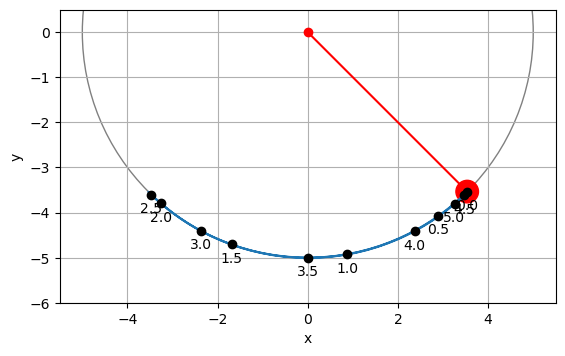

In [13]:
# Function to plot trajectory
def plot_pendulum_trajectory(sol, params, labels=True):

    x, vx, y, vy = sol.y
    t = sol.t
    nT = len(t)
    selected_points = np.arange(0, nT, step=(nT - 1) // 10)
    r_p = params.get('r_p', 0.25)
    
    ax = plt.gca()

    circ = plt.Circle((0, 0), params['L'], facecolor='none', edgecolor='grey')
    ax.add_patch(circ)

    load = plt.Circle((y0[0], y0[2]), r_p, color='r')
    ax.add_patch(load)

    ax.plot(x, y)
    ax.plot([0, y0[0]], [0, y0[2]], '-ro')
    ax.plot(x[selected_points], y[selected_points], 'ko')
    if labels:
        for p in selected_points:
            ax.annotate(f"{t[p]:.1f}", (x[p] - 0.25, y[p] - 0.4))
    ax.set_xlim([-5.5, 5.5])
    ax.set_ylim([-6, 0.5])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    ax.grid()

plot_pendulum_trajectory(sol, params)
plt.show()

## Add aerodynamic drag

In [14]:
def free_pendulum_with_drag(t, y, params):
    """
    y[0] : x position of pendulum mass
    y[1] : dx/dt
    y[2] : y position of pendulum mass
    y[3] : dy/dt
    """
    g = params["g"]
    rho_cd_A = params["rho_cd_A"]
    L = params["L"]
    m_p = params["m_p"]

    # Current states
    x, D_x, y, D_y = y

    # Convert position to polar co-ordinates
    [L, theta] = xy_to_polar(x, y)

    # Convert velocities to polar co-ordinates
    D_L, v_theta = xy_vector_to_polar(theta, D_x, D_y)

    # Convert tangential velocity to angular velocity
    D_theta = v_theta / L

    # Force due to aerodynamic drag
    #F_d = 0.5 * rho_cd_A * (D_r ** 2 + v_theta ** 2)

    # Tangential component of drag force
    F_dtheta = 0.5 * rho_cd_A * v_theta ** 2

    # Radial component of drag force
    #F_dr = 0.5 * rho_cd_A * D_r ** 2

    # Tangential component of acceleration due to forces applied:
    #  - gravity
    #  - aerodynamic drag
    a_theta = -g * np.cos(theta) - np.sign(D_theta) * F_dtheta / m_p

    # Fix length of pendulum
    D2_L = 0

    # Compute radial and tangential acceleration of pendulum mass
    a_L, a_theta = acceleration_components_polar(L, D_L, D2_L, theta, D_theta, a_theta / L)

    # Convert back to xy co-ordinates
    D2_x, D2_y = polar_vector_to_xy(theta, a_L, a_theta)

    return [D_x, D2_x, D_y, D2_y]

In [15]:
params = {
    "L": 5,  # length of cable
    "m_p": 1,  # mass of load
    "g": 9.81,  # acceleration due to gravity
    "r_p": 1  # radius of load
}
params["rho_cd_A"] = 1.293 * 0.47 * np.pi * params["r_p"] ** 2

x0, y0 = polar_to_xy(params["L"], np.radians(-45))
vx0, vy0 = 0, 0
y0 = [x0, vx0, y0, vy0]
y = y0
t = 0

# Choose ODE function
fun = free_pendulum_with_drag
dy = fun(t, y, params)
print(dy)

# Simulation parameters
t_stop = 5
t_step = 0.05
t_eval = np.arange(0, t_stop + t_step, t_step)
t_span = [0, t_stop]

sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, args=(params, ))
print(sol)
assert(sol.status == 0)

[0, -4.905, 0, -4.905000000000001]
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.000e-02 ...  4.950e+00  5.000e+00]
        y: [[ 3.536e+00  3.529e+00 ...  1.888e-01  2.066e-01]
            [ 0.000e+00 -2.442e-01 ...  3.698e-01  3.444e-01]
            [-3.536e+00 -3.542e+00 ... -5.023e+00 -5.022e+00]
            [ 0.000e+00 -2.434e-01 ...  7.204e-03  7.474e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 92
     njev: 0
      nlu: 0


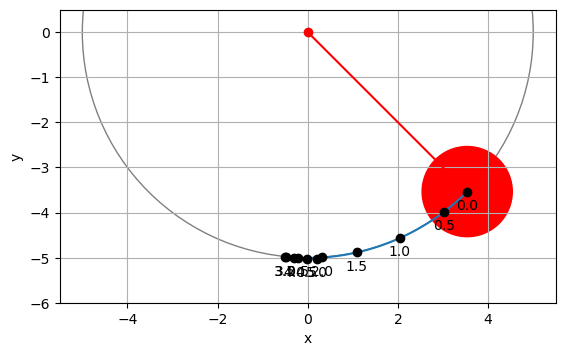

In [16]:
plot_pendulum_trajectory(sol, params)
plt.show()

## Free pendulum with spring arm

In [17]:
def free_pendulum_with_spring(t, y, params):
    """
    y[0] : x position of pendulum mass
    y[1] : dx/dt
    y[2] : y position of pendulum mass
    y[3] : dy/dt
    """
    g = params["g"]
    rho_cd_A = params["rho_cd_A"]
    L = params["L"]
    m_p = params["m_p"]
    k_p = params["k_p"]

    # Current states
    x, D_x, y, D_y = y

    # Convert position to polar co-ordinates
    [r, theta] = xy_to_polar(x, y)

    # Convert velocity to polar co-ordinates
    D_r, v_theta = xy_vector_to_polar(theta, D_x, D_y)

    # Convert tangential velocity to angular velocity
    D_theta = v_theta / r

    # Calculate tension in spring (+ve = tension)
    T = k_p * (r - L)

    # Force due to aerodynamic drag
    #F_d = 0.5 * rho_cd_A * (D_r ** 2 + v_theta ** 2)

    # Tangential component of drag force
    #F_dtheta = 0.5 * rho_cd_A * v_theta ** 2

    # Radial component of drag force
    #F_dr = 0.5 * rho_cd_A * D_r ** 2

    # Radial component of acceleration due to forces applied:
    #  - gravity
    #  - spring tension
    a_r = -g * np.sin(theta) - T / m_p

    # Tangential component of acceleration due to forces applied:
    #  - gravity
    a_theta = -g * np.cos(theta)

    D2_r, D2_theta = centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta)

    # Convert back to xy co-ordinates
    D2_x, D2_y = polar_vector_to_xy(theta, D2_r, D2_theta * r)

    return [D_x, D2_x, D_y, D2_y]

In [18]:
params = {
    "L": 5,  # length of cable
    "m_p": 1,  # mass of load
    "g": 9.81,  # acceleration due to gravity
    "r_p": 0.5,  # radius of load
    "k_p": 50  # spring constant of cable
}
params["rho_cd_A"] = 1.293 * 0.47 * np.pi * params["r_p"] ** 2

x0, y0 = polar_to_xy(params["L"], np.radians(-45))
vx0, vy0 = 0, 0
y0 = [x0, vx0, y0, vy0]
y = y0
t = 0

# Choose ODE function
fun = free_pendulum_with_spring
dy = fun(t, y, params)
print(dy)

# Simulation parameters
t_stop = 5
t_step = 0.05
t_eval = np.arange(0, t_stop + t_step, t_step)
t_span = [0, t_stop]

sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, args=(params, ))
print(sol)
assert(sol.status == 0)

[0, 0.0, 0, -9.81]
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.000e-02 ...  4.950e+00  5.000e+00]
        y: [[ 3.536e+00  3.535e+00 ...  3.530e+00  3.535e+00]
            [ 0.000e+00 -4.235e-03 ...  1.057e-01  1.052e-01]
            [-3.536e+00 -3.548e+00 ... -3.550e+00 -3.535e+00]
            [ 0.000e+00 -4.851e-01 ...  5.455e-01  5.693e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 266
     njev: 0
      nlu: 0


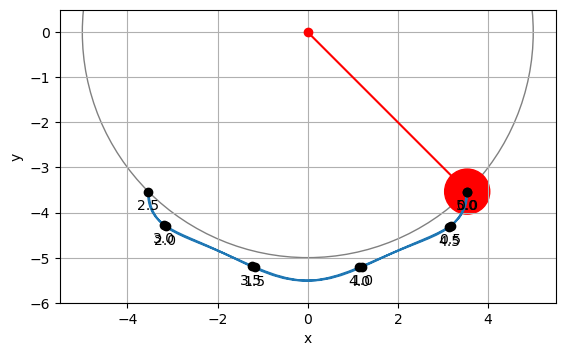

In [19]:
plot_pendulum_trajectory(sol, params)
plt.show()

## Free pendulum with spring arm and aerodynamic drag

In [20]:
def free_pendulum_with_spring_and_drag(t, y, params):
    """
    y[0] : x position of pendulum mass
    y[1] : dx/dt
    y[2] : y position of pendulum mass
    y[3] : dy/dt
    """
    g = params["g"]
    rho_cd_A = params["rho_cd_A"]
    L = params["L"]
    m_p = params["m_p"]
    k_p = params["k_p"]

    # Current states
    x, D_x, y, D_y = y

    # Convert position to polar co-ordinates
    [r, theta] = xy_to_polar(x, y)

    # Convert velocity to polar co-ordinates
    D_r, v_theta = xy_vector_to_polar(theta, D_x, D_y)

    # Convert tangential velocity to angular velocity
    D_theta = v_theta / r

    # Calculate tension in spring (+ve = tension)
    T = k_p * (r - L)

    # Force due to aerodynamic drag
    #F_d = 0.5 * rho_cd_A * (D_r ** 2 + v_theta ** 2)

    # Tangential component of drag force
    F_dtheta = 0.5 * rho_cd_A * v_theta ** 2

    # Radial component of drag force
    F_dr = 0.5 * rho_cd_A * D_r ** 2

    # Radial component of acceleration due to forces applied:
    #  - gravity
    #  - spring tension
    #  - aerodynamic drag
    a_r = -g * np.sin(theta) - T / m_p - np.sign(D_r) * F_dr / m_p

    # Tangential component of acceleration due to forces applied:
    #  - gravity
    #  - aerodynamic drag
    a_theta = -g * np.cos(theta) - np.sign(D_theta) * F_dtheta / m_p

    # Compute second derivatives of radius and angle
    D2_r, D2_theta = centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta)

    # Convert back to xy co-ordinates
    D2_x, D2_y = polar_vector_to_xy(theta, D2_r, D2_theta * r)

    return [D_x, D2_x, D_y, D2_y]

In [21]:
params = {
    "L": 5,  # length of cable
    "m_p": 1,  # mass of load
    "g": 9.81,  # acceleration due to gravity
    "r_p": 0.5,  # radius of load
    "k_p": 50  # spring constant of cable
}
params["rho_cd_A"] = 1.293 * 0.47 * np.pi * params["r_p"] ** 2

x0, y0 = polar_to_xy(params["L"], np.radians(-45))
vx0, vy0 = 0, 0
y0 = [x0, vx0, y0, vy0]
y = y0
t = 0

# Choose ODE function
fun = free_pendulum_with_spring_and_drag
dy = fun(t, y, params)
print(dy)

# Simulation parameters
t_stop = 5
t_step = 0.05
t_eval = np.arange(0, t_stop + t_step, t_step)
t_span = [0, t_stop]

sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, args=(params, ))
print(sol)
assert sol.status == 0, sol.message

[0, 0.0, 0, -9.81]
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.000e-02 ...  4.950e+00  5.000e+00]
        y: [[ 3.536e+00  3.535e+00 ...  1.104e+00  1.092e+00]
            [ 0.000e+00 -4.228e-03 ... -1.675e-01 -2.771e-01]
            [-3.536e+00 -3.548e+00 ... -5.101e+00 -5.078e+00]
            [ 0.000e+00 -4.845e-01 ...  4.480e-01  4.606e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 284
     njev: 0
      nlu: 0


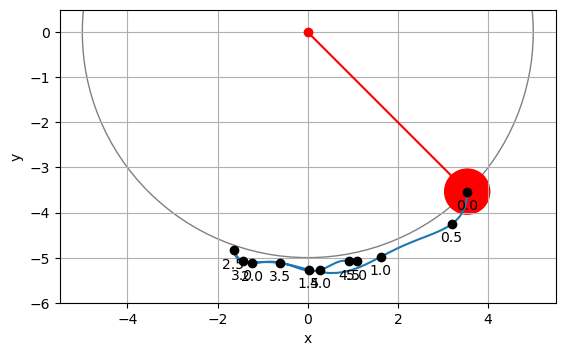

In [22]:
plot_pendulum_trajectory(sol, params)
plt.show()

## Free pendulum with damped spring arm and aerodynamic drag

In [23]:
def free_pendulum_with_damped_spring_and_drag(t, y, params):
    """
    y[0] : x position of pendulum mass
    y[1] : dx/dt
    y[2] : y position of pendulum mass
    y[3] : dy/dt
    """
    g = params["g"]
    rho_cd_A = params["rho_cd_A"]
    L = params["L"]
    m_p = params["m_p"]
    k_p = params["k_p"]
    zeta = params["zeta"]

    # Current states
    x, D_x, y, D_y = y

    # Convert position to polar co-ordinates
    [r, theta] = xy_to_polar(x, y)

    # Convert velocity to polar co-ordinates
    D_r, v_theta = xy_vector_to_polar(theta, D_x, D_y)

    # Convert tangential velocity to angular velocity
    D_theta = v_theta / r

    # Undamped natural frequency of spring-mass system
    omega_n = np.sqrt(k_p / m_p)

    # Coefficient for damping term
    c = 2 * m_p * omega_n * zeta

    # Tension in cable (+ve = tension)
    T = k_p * (r - L) + c * D_r

    # Force due to aerodynamic drag
    #F_d = 0.5 * rho_cd_A * (D_r ** 2 + v_theta ** 2)

    # Tangential component of drag force
    F_dtheta = 0.5 * rho_cd_A * v_theta ** 2

    # Radial component of drag force
    F_dr = 0.5 * rho_cd_A * D_r ** 2

    # Radial component of acceleration due to forces applied:
    #  - gravity
    #  - spring tension
    #  - aerodynamic drag
    a_r = -g * np.sin(theta) - T / m_p - np.sign(D_r) * F_dr / m_p

    # Tangential component of acceleration due to forces applied:
    #  - gravity
    #  - aerodynamic drag
    a_theta = -g * np.cos(theta) - np.sign(D_theta) * F_dtheta / m_p

    # Compute second derivatives of radius and angle
    D2_r, D2_theta = centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta)

    # Convert back to xy co-ordinates
    D2_x, D2_y = polar_vector_to_xy(theta, D2_r, D2_theta * r)

    return [D_x, D2_x, D_y, D2_y]

In [24]:
params = {
    "L": 5,  # length of cable
    "m_p": 1,  # mass of load
    "g": 9.81,  # acceleration due to gravity
    "r_p": 0.5,  # radius of load
    "k_p": 50,  # spring constant of cable
    "zeta": 0.2  # damping ratio
}
params["rho_cd_A"] = 1.293 * 0.47 * np.pi * params["r_p"] ** 2

# Define initial condition
x0, y0 = polar_to_xy(params["L"], np.radians(-45))
vx0, vy0 = 0, 0
y0 = [x0, vx0, y0, vy0]
y = y0
t = 0

# Choose ODE function
fun = free_pendulum_with_damped_spring_and_drag
dy = fun(t, y, params)
print(dy)

# Simulation parameters
t_stop = 5
t_step = 0.05
t_eval = np.arange(0, t_stop + t_step, t_step)
t_span = [0, t_stop]

sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, args=(params, ))
print(sol)
assert sol.status == 0, sol.message

[0, 0.0, 0, -9.81]
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.000e-02 ...  4.950e+00  5.000e+00]
        y: [[ 3.536e+00  3.535e+00 ...  1.088e+00  1.084e+00]
            [ 0.000e+00 -2.043e-02 ... -3.457e-02 -1.340e-01]
            [-3.536e+00 -3.547e+00 ... -5.075e+00 -5.076e+00]
            [ 0.000e+00 -4.683e-01 ... -3.249e-03 -2.889e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 236
     njev: 0
      nlu: 0


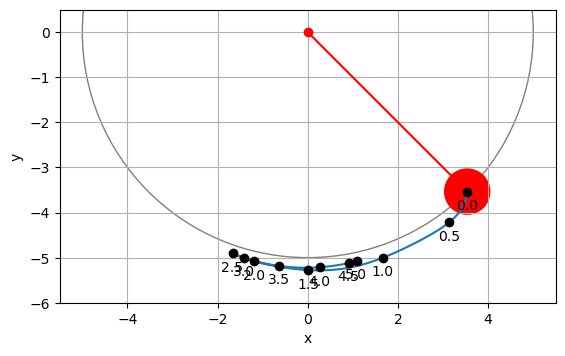

In [25]:
plot_pendulum_trajectory(sol, params)
plt.show()

## Pendulum with forced arm tension

In [26]:
def pendulum_with_forced_arm_tension(t, y, params):
    """
    y[0] : x position of pendulum mass
    y[1] : dx/dt
    y[2] : y position of pendulum mass
    y[3] : dy/dt
    """
    g = params["g"]
    rho_cd_A = params["rho_cd_A"]
    L = params["L"]
    m_p = params["m_p"]
    #k_p = params["k_p"]
    #zeta = params["zeta"]
    
    assert rho_cd_A == 0

    # Current states
    x, D_x, y, D_y = y

    # Convert position to polar co-ordinates
    [r, theta] = xy_to_polar(x, y)

    # Convert velocity to polar co-ordinates
    D_r, v_theta = xy_vector_to_polar(theta, D_x, D_y)

    # Convert tangential velocity to angular velocity
    D_theta = v_theta / r

    # Exogenous input - tension in cable (+ve = tension)
    if t > 1 and t < 3:
        T = 0
    else:
        T = 0

    assert T == 0
    # Undamped natural frequency of spring-mass system
    #omega_n = np.sqrt(k_p / m_p)

    # Coefficient for damping term
    #c = 2 * m_p * omega_n * zeta

    # Tension in cable (+ve = tension)
    #T = k_p * (r - L) + c * D_r

    # Force due to aerodynamic drag
    #F_d = 0.5 * rho_cd_A * (D_r ** 2 + v_theta ** 2)

    # Tangential component of drag force
    F_dtheta = 0.5 * rho_cd_A * v_theta ** 2
    if F_dtheta != 0:
        breakpoint()

    # Radial component of drag force
    F_dr = 0.5 * rho_cd_A * D_r ** 2
    assert F_dr == 0

    # Radial component of acceleration due to forces applied:
    #  - gravity
    #  - cable tension
    #  - aerodynamic drag
    a_r = -g * np.sin(theta) - T / m_p - np.sign(D_r) * F_dr / m_p

    # Tangential component of acceleration due to forces applied:
    #  - gravity
    #  - aerodynamic drag
    a_theta = -g * np.cos(theta) - np.sign(D_theta) * F_dtheta / m_p

    # Compute second derivatives of radius and angle
    D2_r, D2_theta = centripetal_motion_polar_D2(a_r, r, D_r, a_theta, theta, D_theta)
    
    # TODO: Something wrong here, not sure translating accelerations back
    #       to x-y co-ordinates works (u_rho and u_theta are rotating and accelerating!)

    # Convert back to xy co-ordinates
    D2_x, D2_y = polar_vector_to_xy(theta, D2_r, D2_theta * r)

    return [D_x, D2_x, D_y, D2_y]

In [27]:
params = {
    "L": 5,  # length of cable
    "m_p": 1,  # mass of load
    "g": 9.81,  # acceleration due to gravity
    "r_p": 0,  # radius of load
    "k_p": 50,  # spring constant of cable
    "zeta": 0.2  # damping ratio
}
params["rho_cd_A"] = 1.293 * 0.47 * np.pi * params["r_p"] ** 2

# Define initial condition
x0, y0 = polar_to_xy(params["L"], np.radians(0))
vx0, vy0 = 0, 0
y0 = [x0, vx0, y0, vy0]
y = y0
t = 0

# Choose ODE function
fun = pendulum_with_forced_arm_tension
dy0 = fun(t, y, params)
print(f"y0: {y0}\ndy0: {dy0}")

# Simulation parameters
t_stop = 1.5
t_step = 0.05
t_eval = np.arange(0, t_stop + t_step, t_step)
t_span = [0, t_stop]

rtol = 1e-5
atol = 1e-8

sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, rtol=rtol, atol=atol, args=(params, ))
print(sol)
assert sol.status == 0, sol.message

y0: [5.0, 0, 0.0, 0]
dy0: [0, 0.0, 0, -9.81]
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.000e-02 ...  1.450e+00  1.500e+00]
        y: [[ 5.000e+00  5.000e+00 ...  8.408e+00  8.715e+00]
            [ 0.000e+00  8.019e-04 ...  6.035e+00  6.250e+00]
            [ 0.000e+00 -1.226e-02 ... -8.126e+00 -8.628e+00]
            [ 0.000e+00 -4.905e-01 ... -9.864e+00 -1.018e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 80
     njev: 0
      nlu: 0


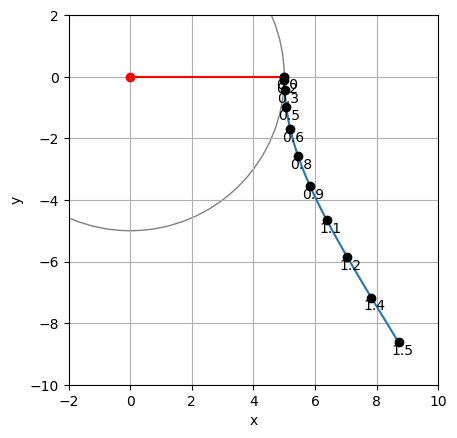

In [28]:
plot_pendulum_trajectory(sol, params)
plt.xlim([-2, 10])
plt.ylim([-10, 2])
plt.show()

In [29]:
t = 0
dt = 0.05
[x, D_x, y, D_y] = y0
print(f"{'t':>5s} {'x':>5s} {'D_x':>5s} {'y':>5s} {'D_y':>5s}")
print(f"{t:5.2f} {x:5.2f} {D_x:5.2f} {y:5.2f} {D_y:5.2f}")

for i in range(10):
    D_x, D2_x, D_y, D2_y = pendulum_with_forced_arm_tension(t, [x, D_x, y, D_y], params)
    x += D_x * dt; y += D_y * dt
    D_x += D2_x * dt; D_y += D2_y * dt
    t += dt
    print(f"{t:5.2f} {x:5.2f} {D_x:5.2f} {y:5.2f} {D_y:5.2f}")

    t     x   D_x     y   D_y
 0.00  5.00  0.00  0.00  0.00
 0.05  5.00  0.00  0.00 -0.49
 0.10  5.00  0.00 -0.02 -0.98
 0.15  5.00  0.01 -0.07 -1.47
 0.20  5.00  0.03 -0.15 -1.96
 0.25  5.00  0.07 -0.25 -2.45
 0.30  5.01  0.13 -0.37 -2.93
 0.35  5.01  0.22 -0.51 -3.41
 0.40  5.02  0.33 -0.68 -3.87
 0.45  5.04  0.48 -0.88 -4.32
 0.50  5.06  0.67 -1.09 -4.74


In [30]:
print(x, D_x)

5.064381680164544 0.6680240869040566


In [31]:
params = {
    "L": 5,  # length of cable
    "m_p": 1,  # mass of load
    "g": 9.81,  # acceleration due to gravity
    "r_p": 0  # radius of load
}
params["rho_cd_A"] = 1.293 * 0.47 * np.pi * params["r_p"] ** 2

fun = pendulum_with_forced_arm_tension
t_stop = 0.5
t_step = 0.05
t_eval = np.arange(0, t_stop + t_step, t_step)
t_span = [0, t_stop]
sol = solve_ivp(fun, t_span, y0, t_eval=t_eval,
                rtol=1e-5, atol=1e-8, args=(params, ))
assert sol.status == 0, sol.message
x, D_x, y, D_y = sol.y[:, -1]
print(f"{'t':>5s} {'x':>5s} {'D_x':>5s} {'y':>5s} {'D_y':>5s}")
for t, (x, D_x, y, D_y) in zip(sol.t, sol.y.T):
    print(f"{t:5.2f} {x:5.2f} {D_x:5.2f} {y:5.2f} {D_y:5.2f}")

    t     x   D_x     y   D_y
 0.00  5.00  0.00  0.00  0.00
 0.05  5.00  0.00 -0.01 -0.49
 0.10  5.00  0.01 -0.05 -0.98
 0.15  5.00  0.02 -0.11 -1.47
 0.20  5.00  0.05 -0.20 -1.96
 0.25  5.01  0.10 -0.31 -2.44
 0.30  5.01  0.17 -0.44 -2.92
 0.35  5.02  0.27 -0.60 -3.39
 0.40  5.04  0.40 -0.78 -3.84
 0.45  5.06  0.56 -0.98 -4.27
 0.50  5.10  0.76 -1.21 -4.67


In [32]:
print(x, D_x)

5.09753143607141 0.7595240006838602


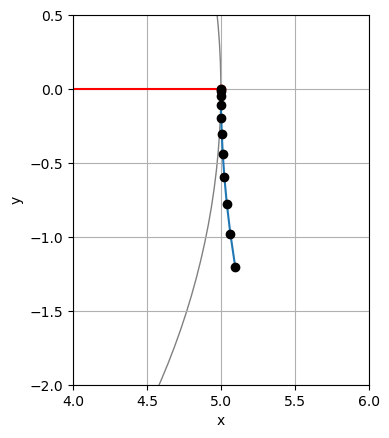

In [33]:
plot_pendulum_trajectory(sol, params, labels=False)
plt.xlim([4, 6])
plt.ylim([-2, 0.5])
plt.savefig("test_g.png")
plt.show()

## Pendulum with controlled arm length

In [34]:
def pendulum_with_controlled_arm_length(t, y, params):
    """
    y[0] : x position of pendulum mass
    y[1] : dx/dt
    y[2] : y position of pendulum mass
    y[3] : dy/dt
    """
    g = params["g"]
    rho_cd_A = params["rho_cd_A"]
    L = params["L"]
    m_p = params["m_p"]
    k_p = params["k_p"]
    zeta = params["zeta"]
    K_c = params["K_c"]

    # Current states
    x, D_x, y, D_y = y

    # Convert position to polar co-ordinates
    [r, theta] = xy_to_polar(x, y)

    # Convert velocity to polar co-ordinates
    D_r, v_theta = xy_vector_to_polar(theta, D_x, D_y)

    # Convert tangential velocity to angular velocity
    D_theta = v_theta / r

    # Arm length controller (T +ve = tension)
    T = np.clip(K_c * (r - L), -2, 2)

    # Coefficient for damping term
    #c = 2 * m_p * omega_n * zeta

    # Tension in cable (+ve = tension)
    #T = k_p * (r - L) + c * D_r

    # Force due to aerodynamic drag
    #F_d = 0.5 * rho_cd_A * (D_r ** 2 + v_theta ** 2)

    # Tangential component of drag force
    F_dtheta = 0.5 * rho_cd_A * D_theta ** 2

    # Radial component of drag force
    F_dr = 0.5 * rho_cd_A * D_r ** 2

    # Radial component of acceleration due to forces applied:
    #  - gravity
    #  - spring tension
    #  - aerodynamic drag
    a_r = -g * np.sin(theta) - T / m_p - np.sign(D_r) * F_dr / m_p

    # Tangential component of acceleration due to forces applied:
    #  - gravity
    a_theta = -g * np.cos(theta) - np.sign(D_theta) * F_dtheta / m_p

    # Compute radial and angular acceleration of pendulum mass
    a_L, a_theta = acceleration_components_polar(r, D_L, a_r, theta, D_theta, a_theta / r)

    # Convert back to xy co-ordinates
    D2_x, D2_y = polar_vector_to_xy(theta, a_L, a_theta)

    return [D_x, D2_x, D_y, D2_y]

In [35]:
params = {
    "L": 5,  # length of cable (m)
    "m_p": 1,  # mass of load (kg)
    "g": 9.81,  # acceleration due to gravity (m.s^-2)
    "r_p": 0.5,  # radius of load (m)
    "k_p": 10,  # spring constant of cable
    "zeta": 0.15,  # damping ratio
    "K_c": 50  # gain of arm length controller
}
params["rho_cd_A"] = 1.293 * 0.47 * np.pi * params["r_p"] ** 2

# Define initial condition
x0, y0 = polar_to_xy(params["L"], -np.pi/2) # polar_to_xy(params["L"], np.radians(-45))
vx0, vy0 = 0, 0
y0 = [x0, vx0, y0, vy0]
y = y0
t = 0

# Choose ODE function
fun = pendulum_with_controlled_arm_length
dy = fun(t, y, params)
print(f"y0: {y0}\ndy0: {dy}")

# Simulation parameters
t_stop = 10
t_step = 0.05
t_eval = np.arange(0, t_stop + t_step, t_step)
t_span = [0, t_stop]

sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, args=(params, ))
print(sol)
assert sol.status == 0, sol.message

NameError: name 'D_L' is not defined

In [ ]:
plot_pendulum_trajectory(sol, params)
plt.show()